<a href="https://colab.research.google.com/github/EmilyFotopoulou/Time_Series_Forecasting/blob/main/Multiverse_TimeSeries_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Housekeeping 🧹:
Example of seasonality


# Seasonality:
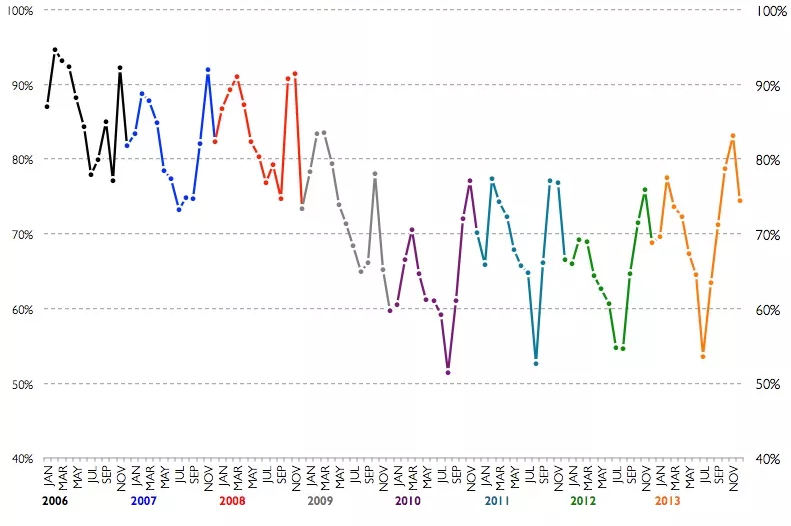

Seasonality -> reoccuring patterns over set **Time intervals**.

Cyclic Patterns -> patterns **Not** linked to **Time intervals**.

# Imports

In [ ]:
#data analysis
import numpy as np
import pandas as pd
from datetime import timedelta

#plots
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

#statistics
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')

# Load files

In [ ]:
#import csv file & covert to dataframe for manipulation
births = pd.read_csv("/content/US_births_2000-2014_SSA.csv")

#view first 5 rows of csv
births.head()

,year,month,date_of_month,day_of_week,births
0,2000,1,1,6,9083
1,2000,1,2,7,8006
2,2000,1,3,1,11363
3,2000,1,4,2,13032
4,2000,1,5,3,12558


In [ ]:
#join columns of dates as a single new string
births["date"] = births[["year","month","date_of_month"]].astype(str).agg('-'.join, axis=1)
births.head()

,year,month,date_of_month,day_of_week,births,date
0,2000,1,1,6,9083,2000-1-1
1,2000,1,2,7,8006,2000-1-2
2,2000,1,3,1,11363,2000-1-3
3,2000,1,4,2,13032,2000-1-4
4,2000,1,5,3,12558,2000-1-5


In [ ]:
#change date type of string to month date
births["date_m"] = pd.to_datetime(births["date"], format="%Y-%m-%d").dt.to_period("m")
#confirm data types
births.dtypes

,0
year,int64
month,int64
date_of_month,int64
day_of_week,int64
births,int64
date,object
date_m,period[M]


In [ ]:
#viusalise first 5 rows with the new columns
births.head()

,year,month,date_of_month,day_of_week,births,date,date_m
0,2000,1,1,6,9083,2000-1-1,2000-01
1,2000,1,2,7,8006,2000-1-2,2000-01
2,2000,1,3,1,11363,2000-1-3,2000-01
3,2000,1,4,2,13032,2000-1-4,2000-01
4,2000,1,5,3,12558,2000-1-5,2000-01


seasonality over weeks? months?

In [ ]:
#count the sum births per Month and save them into a new df
births_perM = pd.DataFrame(births.groupby("date_m")["births"].sum().reset_index())
#update columns in new df
births_perM.columns = ["M-Y", "Births_per_month"]

births_perM

,M-Y,Births_per_month
0,2000-01,337739
1,2000-02,324046
2,2000-03,347824
3,2000-04,323357
4,2000-05,347950
...,...,...
175,2014-08,356066
176,2014-09,350497
177,2014-10,344471
178,2014-11,318655


# Plot - Time series

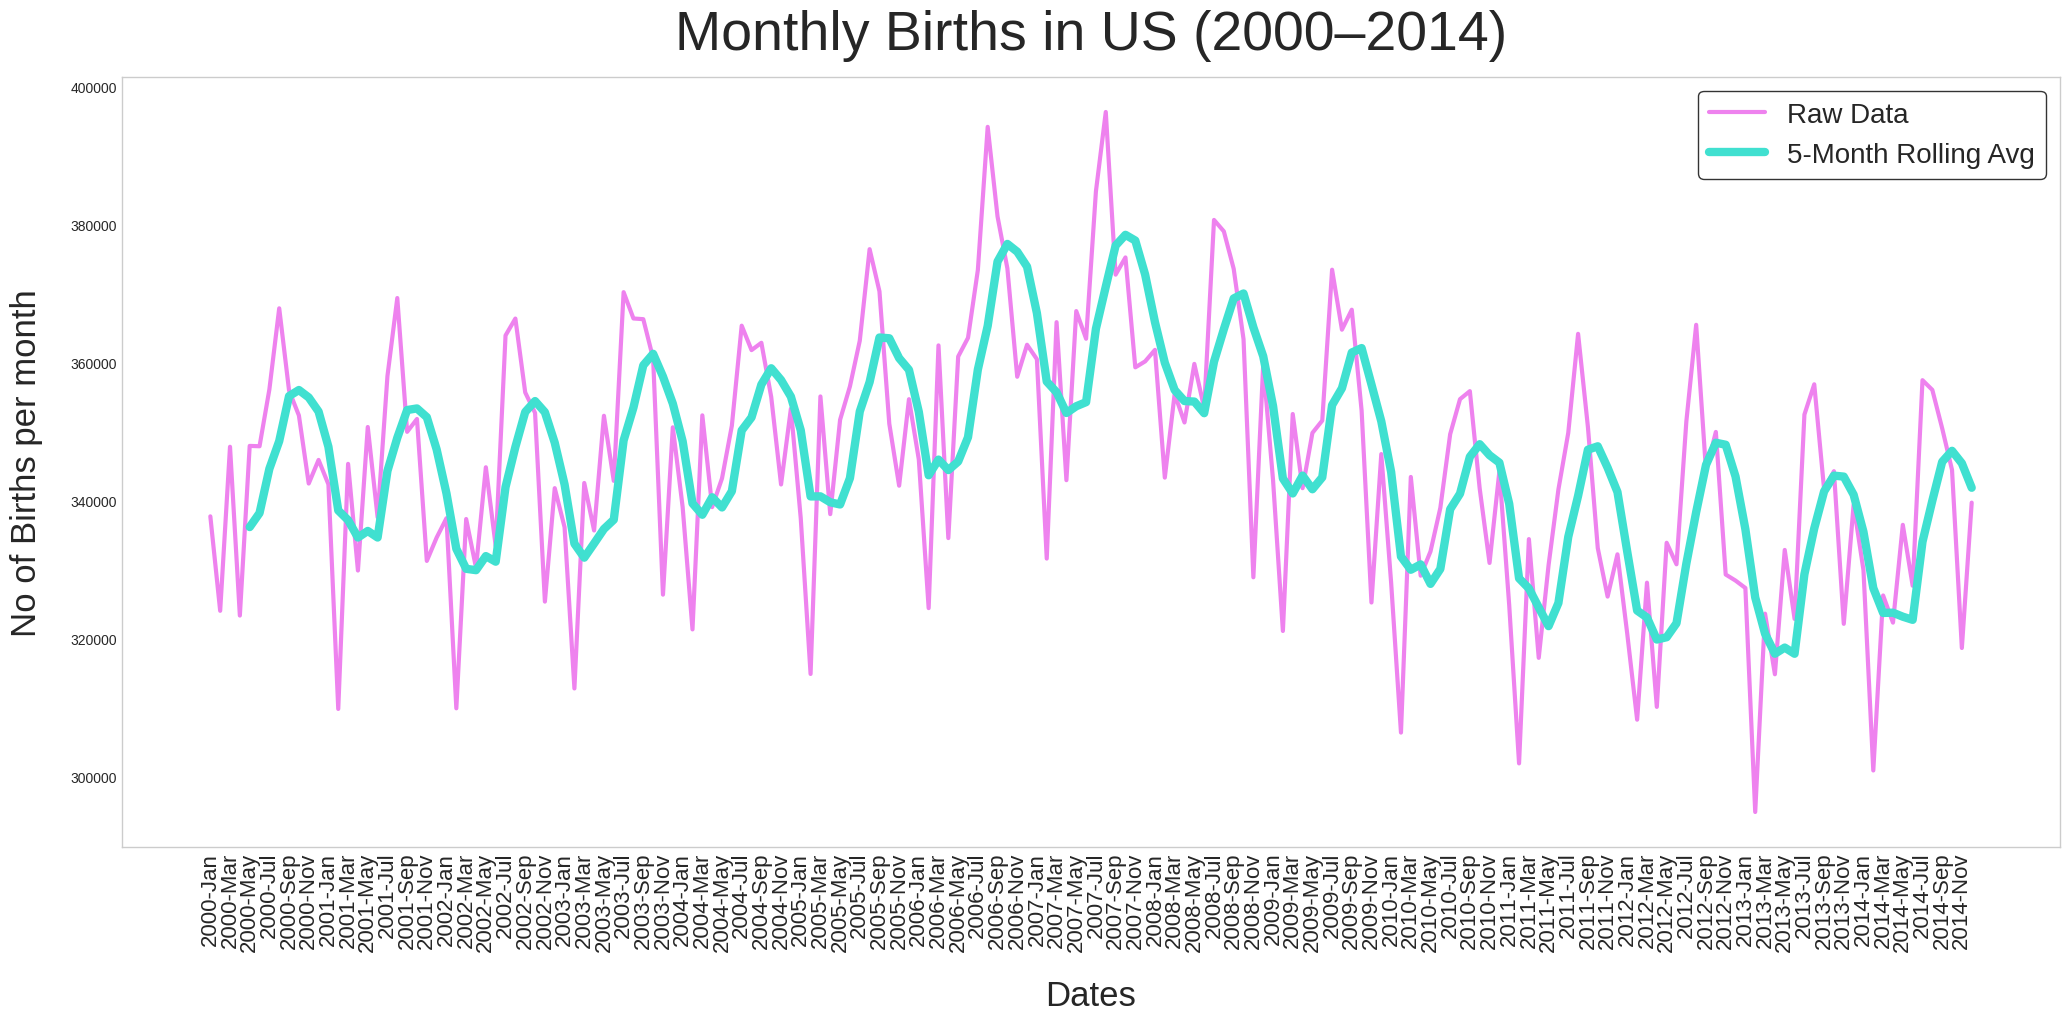

In [ ]:
#visual tools
plt.style.use("seaborn-v0_8-whitegrid")
plt.subplots(figsize=(25,10))
plt.grid(False)

#adjust dates into format where the month is written in words
x_dates = births_perM["M-Y"].dt.strftime("%Y-%b")
#create range for the number of dates
x_range = np.arange(len(x_dates))


#plot raw data as time series
plot = sns.lineplot(x=x_range, y=births_perM["Births_per_month"],
                    color="violet", linewidth=3, label="Raw Data")

#plot 5 month rolling average to reduce noise
plot = sns.lineplot(x=x_range, y=births_perM["Births_per_month"].rolling(5).mean(),
                    color="turquoise", linewidth=6, label="5-Month Rolling Avg")

#set ticks for x labels
plt.xticks(x_range, x_dates, fontsize=16, rotation=90)

#only print every second month of the x-axis to save space
for ind, label in enumerate(plot.get_xticklabels()):
    label.set_visible(ind % 2 == 0)


#labels for axes
plt.xlabel("Dates", fontsize=25, labelpad=20)
plt.ylabel("No of Births per month", fontsize=25, labelpad=20)

#add legend box
plt.legend(loc="best", fontsize=20, frameon=True, edgecolor="black")
#Title for figure
plt.title("Monthly Births in US (2000–2014)", fontsize=40, pad=20)
#If we want to export figure
#fig.savefig("Clinical_Normalised_All.png", bbox_inches="tight")

plt.show()

we definitelly have seasonality and a drop Febuary till early June

# Time-Series Using ARIMA

Forecasting model: Autoregressive Integrated Moving Average


Assumptions:
Data needs to be stationary
- mean contant
- variance constant
- no lags


because we have increases in the trends, it means our data are not stationary.
aka mean,variance = increasing

So we have to adjust this



In [ ]:
# Make the data stationary
# Through BoxCox transform and Differencing
births_perM['Births_Boxcox'], lam = boxcox(births_perM['Births_per_month'])
births_perM["Births_diff"] = births_perM['Births_Boxcox'].diff()
births_perM.dropna(inplace=True)
births_perM.head()

,M-Y,Births_per_month,Births_Boxcox,Births_diff
1,2000-02,324046,1.662066e+08,-1.082887e+07
2,2000-03,347824,1.851603e+08,1.895369e+07
3,2000-04,323357,1.656680e+08,-1.949233e+07
4,2000-05,347950,1.852626e+08,1.959463e+07
5,2000-06,347899,1.852212e+08,-4.141022e+04


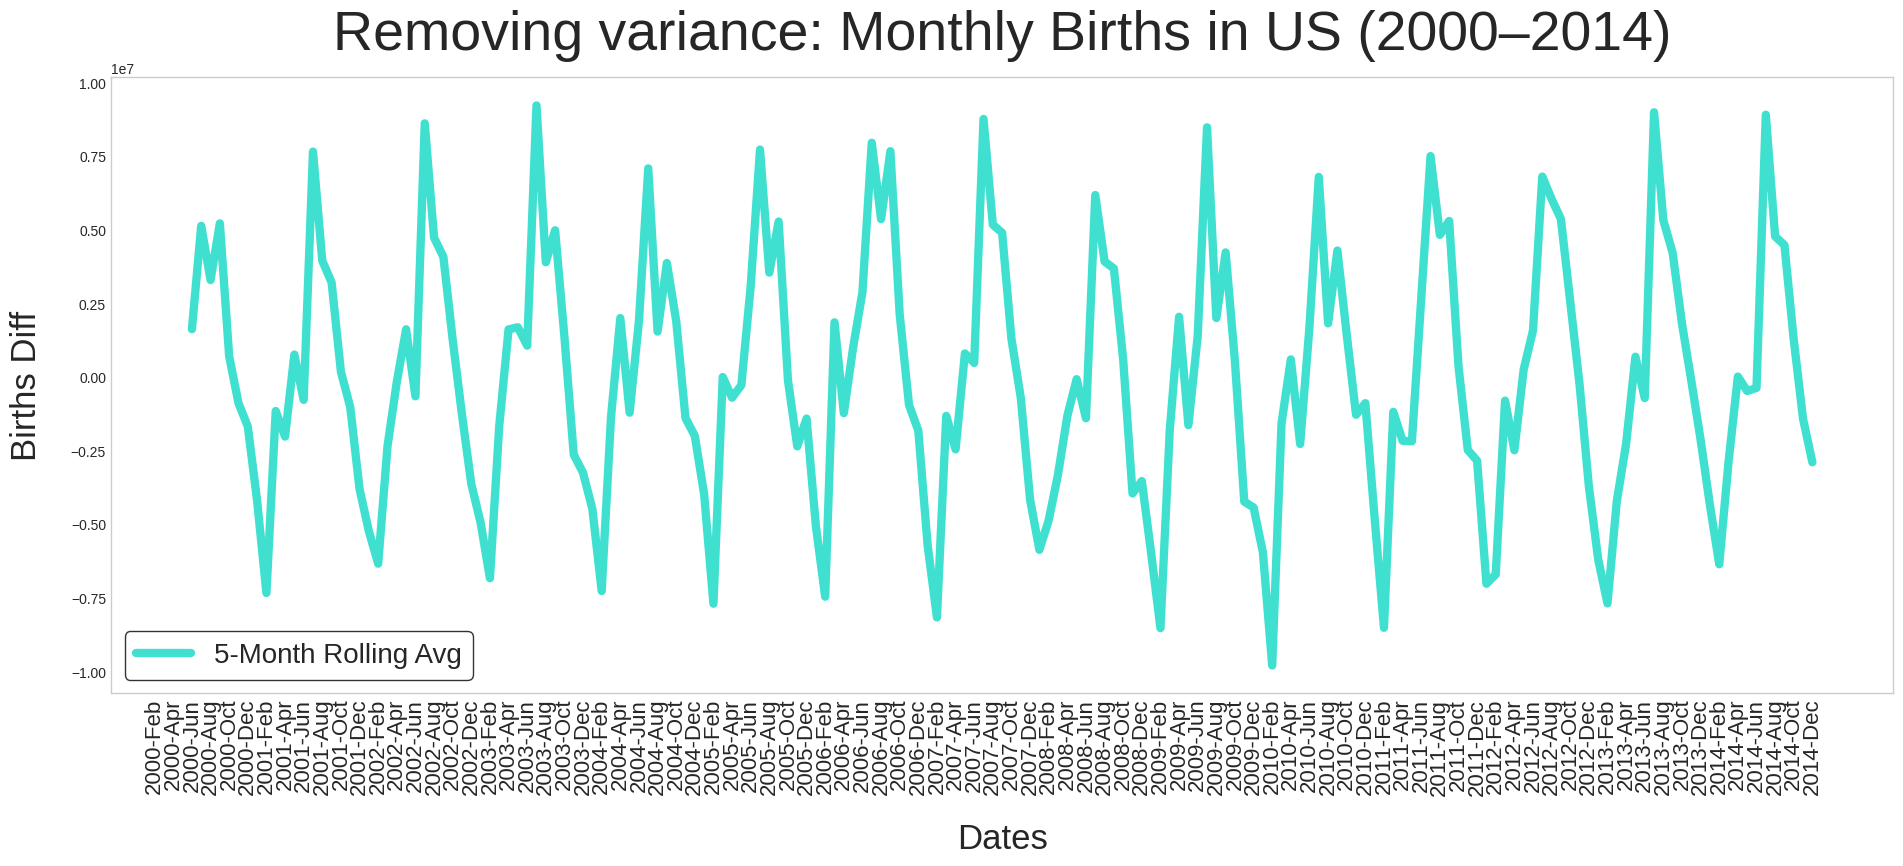

In [ ]:
#visual tools
plt.style.use("seaborn-v0_8-whitegrid")
plt.subplots(figsize=(23,8))
plt.grid(False)

#adjust dates into format where the month is written in words
x_dates = births_perM["M-Y"].dt.strftime("%Y-%b")
#create range for the number of dates
x_range = np.arange(len(x_dates))

plot = sns.lineplot(x=x_range, y=births_perM['Births_diff'].rolling(5).mean(),
                    color="turquoise", linewidth=6, label="5-Month Rolling Avg")


#labels
#set ticks for x labels
plt.xticks(x_range, x_dates, fontsize=16, rotation=90)

#only print every second month of the x-axis to save space
for ind, label in enumerate(plot.get_xticklabels()):
    label.set_visible(ind % 2 == 0)
#labels for axes
plt.xlabel("Dates", fontsize=25, labelpad=20)
plt.ylabel("Births Diff", fontsize=25, labelpad=20)

#add legend box
plt.legend(loc="best", fontsize=20, frameon=True, edgecolor="black")
#Title for figure
plt.title("Removing variance: Monthly Births in US (2000–2014)", fontsize=40, pad=20)
#If we want to export figure
#fig.savefig("Clinical_Normalised_All.png", bbox_inches="tight")

plt.show()

# Modeling

Use ACF and PACF correlograms to deduce the orders for the autoregressive and moving-average components

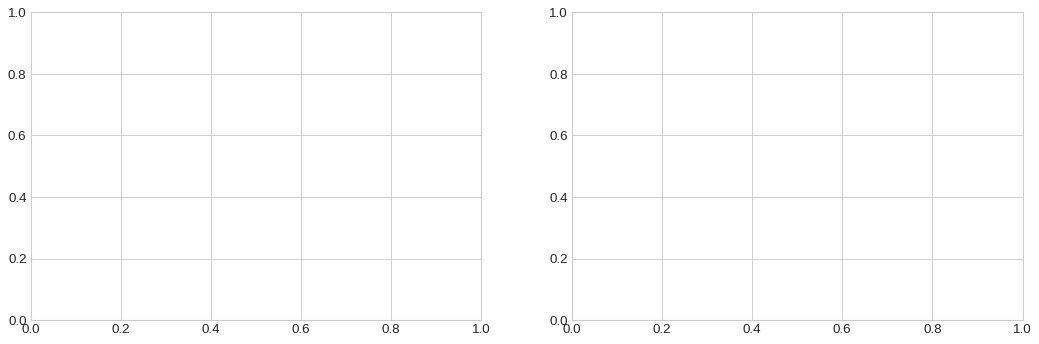

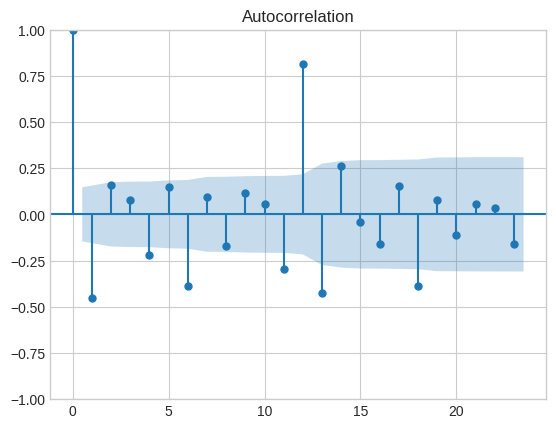

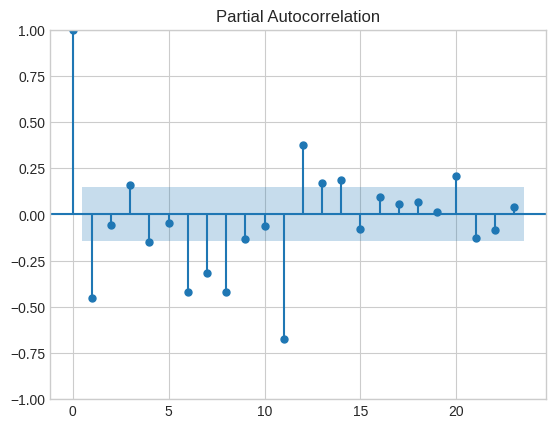

In [ ]:
# Plot acf and pacf
# ACF: Auto correlation function
# PACF: Partial Autocorrelation function
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), dpi=80)
plot_acf(births_perM['Births_diff'])
plot_pacf(births_perM['Births_diff'], method='ywm')
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
plt.show()

In [ ]:
births_perM

,M-Y,Births_per_month,Births_Boxcox,Births_diff
1,2000-02,324046,1.662066e+08,-1.082887e+07
2,2000-03,347824,1.851603e+08,1.895369e+07
3,2000-04,323357,1.656680e+08,-1.949233e+07
4,2000-05,347950,1.852626e+08,1.959463e+07
5,2000-06,347899,1.852212e+08,-4.141022e+04
...,...,...,...,...
175,2014-08,356066,1.918930e+08,-1.160064e+06
176,2014-09,350497,1.873348e+08,-4.558244e+06
177,2014-10,344471,1.824451e+08,-4.889633e+06
178,2014-11,318655,1.620082e+08,-2.043692e+07


In [ ]:
# Ensure the index is datetime
births_perM["M-Y"] = pd.to_datetime(births_perM["M-Y"].astype(str))
births_perM.set_index("M-Y", inplace=True)
births_perM.head()

,Births_per_month,Births_Boxcox,Births_diff
M-Y,,,
2000-02-01,324046,1.662066e+08,-1.082887e+07
2000-03-01,347824,1.851603e+08,1.895369e+07
2000-04-01,323357,1.656680e+08,-1.949233e+07
2000-05-01,347950,1.852626e+08,1.959463e+07
2000-06-01,347899,1.852212e+08,-4.141022e+04


In [ ]:
# Split train and test
train = births_perM.iloc[:-int(len(births_perM) * 0.2)]
test = births_perM.iloc[-int(len(births_perM) * 0.2):]

This is an 80/20 train/test split, so your model is trained on ~80% of the time series, and validated on the remaining 20%. In this case, you have monthly data from 2000 to 2014, so:

- Train covers roughly 2000–2012

- Test covers roughly 2013–2014

In [ ]:
# Build ARIMA model
# ARIMA(p,d,q)
model = ARIMA(train['Births_Boxcox'], order=(1, 1, 0),
              seasonal_order=(1, 1, 1, 12)).fit()
boxcox_forecasts = model.forecast(len(test))
forecasts = inv_boxcox(boxcox_forecasts, lam)

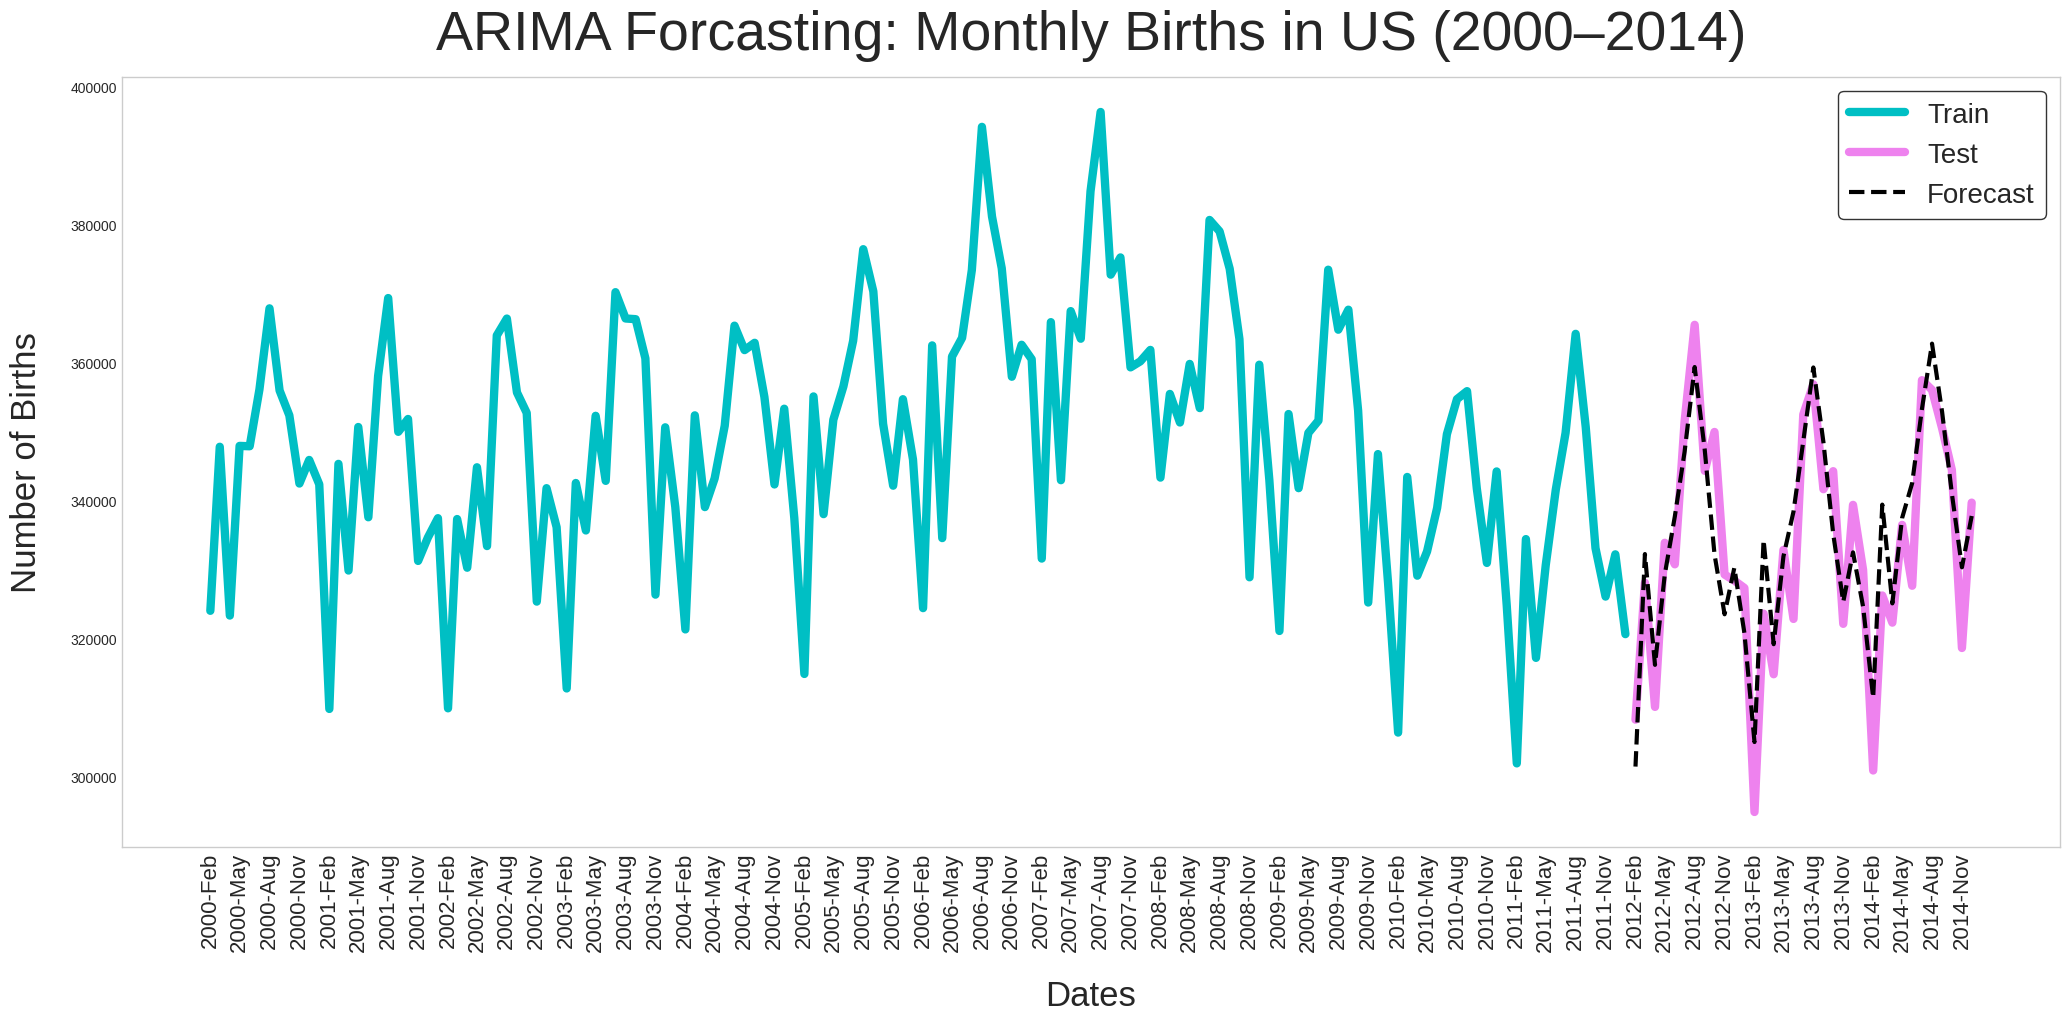

In [ ]:
#visualisation
plt.style.use("seaborn-v0_8-whitegrid")
fig,ax = plt.subplots(figsize=(25,10))
plt.grid(False)

#adjust dates into format where the month is written in words
train_dates = train.index#.dt.strftime("%Y-%b")
test_dates = test.index#.dt.strftime("%Y-%b")

#plot training data
plot = sns.lineplot(x=train_dates, y=train['Births_per_month'],
                   color="#00BFC4", linewidth=6, label="Train")
#plot validation data
plot = sns.lineplot(x=test_dates, y=test['Births_per_month'],
                    color="violet", linewidth=6, label="Test")
#plot forecast
plot = sns.lineplot(x=test_dates, y=forecasts,
                    color="black", linewidth=3, label="Forecast", linestyle='--')

# labels
# set ticks for x labels
all_dates  = train.index.union(test.index).sort_values()
plt.xticks(all_dates, all_dates.strftime('%Y-%b'), fontsize=16, rotation=90)

#only print every second month of the x-axis to save space
for ind, label in enumerate(plot.get_xticklabels()):
    label.set_visible(ind % 3 == 0)
#labels for axes
plt.xlabel("Dates", fontsize=25, labelpad=20)
plt.ylabel("Number of Births", fontsize=25, labelpad=20)

#add legend box
plt.legend(loc="best", fontsize=20, frameon=True, edgecolor="black")
#Title for figure
plt.title("ARIMA Forecasting: Monthly Births in US (2000–2014)", fontsize=40, pad=20)
#If we want to export figure
#fig.savefig("Clinical_Normalised_All.png", bbox_inches="tight")

plt.show()

# Optional: Forecasts the next year ⏰

#### model fitting

In [ ]:
# Forecast next 12 months (out-of-sample)
#model fitting
n_steps = 12
future_boxcox = model.forecast(steps=n_steps)
future_forecast = inv_boxcox(future_boxcox, lam)

#### generate forecasting data

In [ ]:
# Generate future datetime index
last_date = births_perM.index.max()  # now datetime, not period
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1),
                             periods=n_steps, freq='MS')

# Create forecast series
future_series = pd.Series(future_forecast, index=future_dates)

# Combine past data with future forecast for full plot
full_series = pd.concat([births_perM["Births_per_month"], future_series])

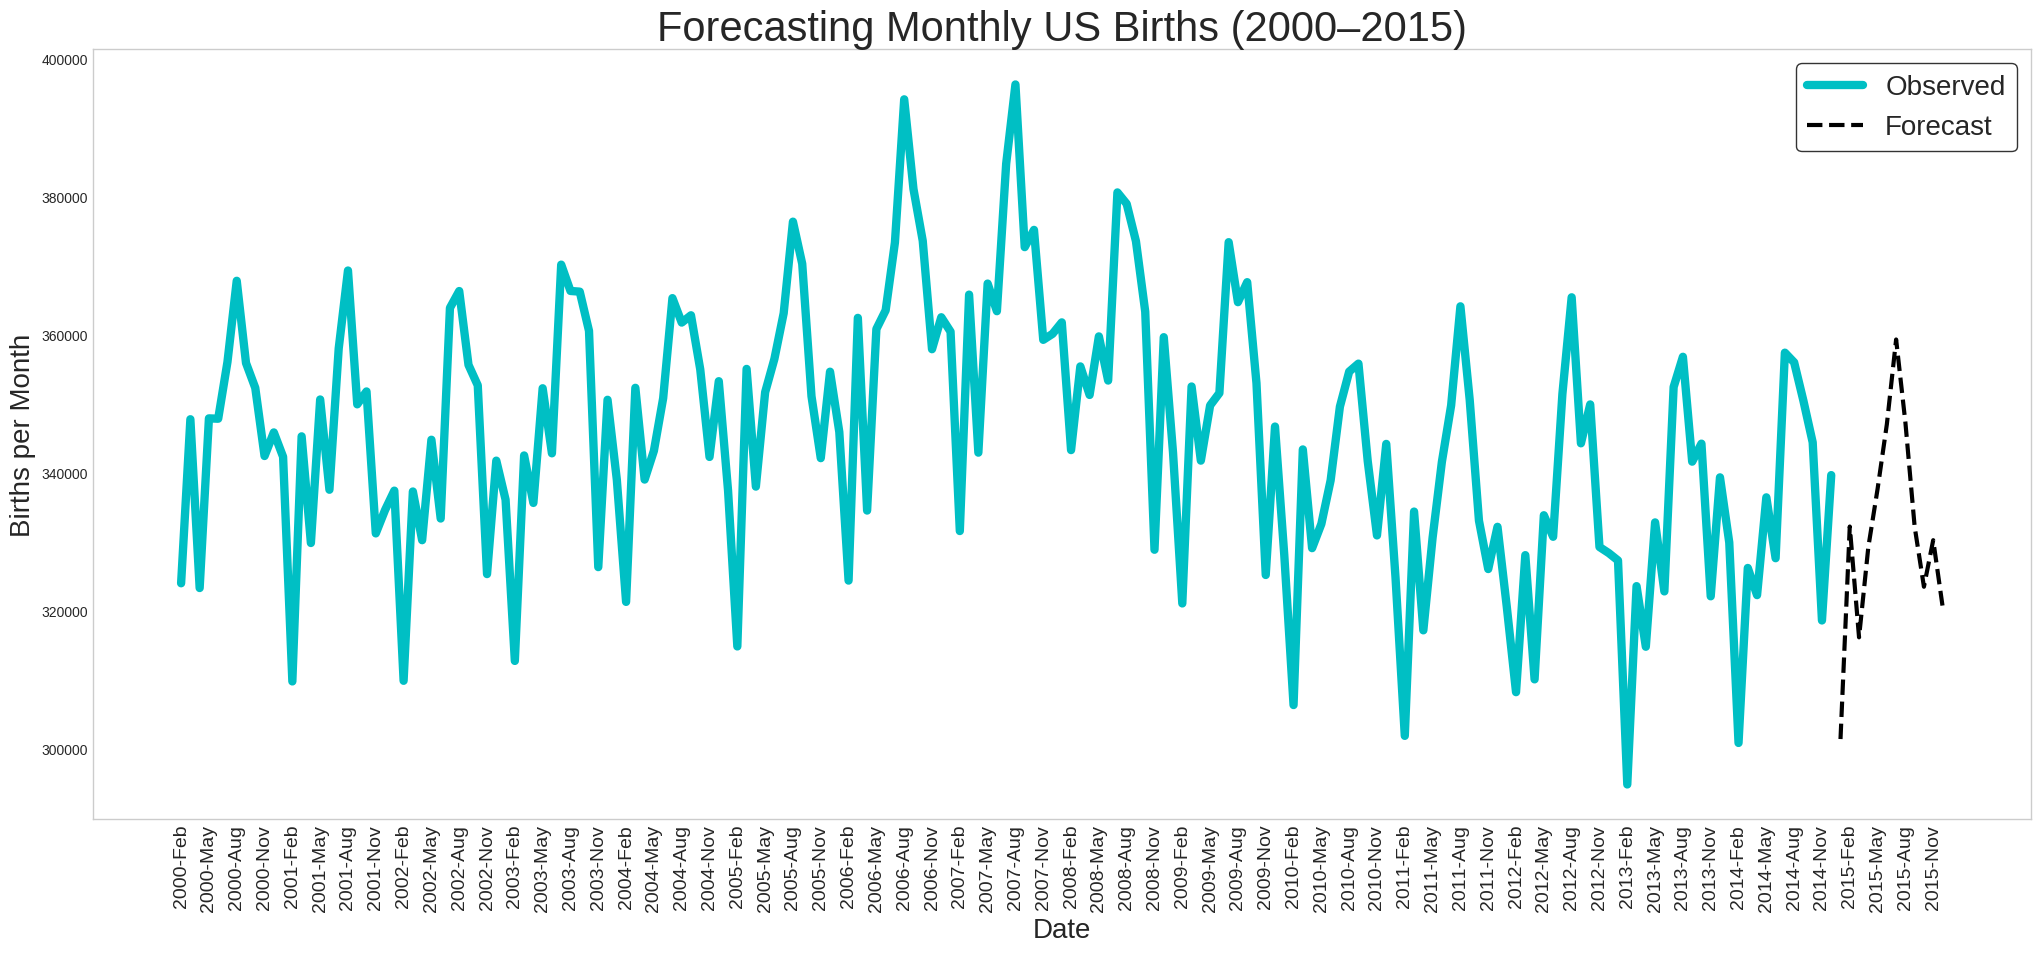

In [ ]:
# Plot all data
plt.figure(figsize=(25, 10))
plt.style.use("seaborn-v0_8-whitegrid")
plt.grid(False)

# Format x-axis
x_dates = full_series.index.strftime("%Y-%b")
x_range = np.arange(len(x_dates))

# Plot actual data
sns.lineplot(x=x_range[:len(births_perM)],
             y=births_perM["Births_per_month"],
             color="#00BFC4", linewidth=6, label="Observed")

# Plot forecast
sns.lineplot(x=x_range[-n_steps:],
             y=future_forecast,
             color="black", linewidth=3, linestyle='--', label="Forecast")

# Set x-ticks
plt.xticks(x_range, x_dates, fontsize=14, rotation=90)
for i, label in enumerate(plt.gca().get_xticklabels()):
    label.set_visible(i % 3 == 0)

# Labels and title
plt.xlabel("Date", fontsize=20)
plt.ylabel("Births per Month", fontsize=20)
plt.title("Forecasting Monthly US Births (2000–2015)", fontsize=30)
plt.legend(fontsize=20, frameon=True, edgecolor="black")

plt.show()